In [1]:
import os
import re
import random
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

PIVOTED_FILE = "pivoted_data.parquet"
ANOMALY_WINDOWS_FILE = "anomaly_windows.csv"
OUT_DIR = os.path.join("userData", "pivoted_paper_improved")
os.makedirs(OUT_DIR, exist_ok=True)

SEQ_LEN = 1
ENCODER_UNITS = [16] * 7
DECODER_UNITS = [16] * 7
GRU_ACT = "tanh"
USE_BOTTLENECK = True
BOTTLENECK_SIZE = 14

W_LONG, W_SHORT = 30, 2

PAPER_THR = 0.9973
ROUND_RES = "5T"
EVENT_GAP_MINUTES = 60
PCT_PROB = 0.05

EPOCHS = 60
BATCH_SIZE = 64
LR = 1e-4

INCLUDE_PATTERNS = [r"(5xx|_5\d\d_)", r"_count$"]

In [3]:
def _compile(pats):
    return [re.compile(p, re.I) for p in (pats or [])]

_inc = _compile(INCLUDE_PATTERNS)
def _keep(col_name):
    return all(r.search(col_name) for r in _inc)

def read_parquet_smart(path, time_col="interval_start"):
    df = pd.read_parquet(path)
    if time_col in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
        df = df.sort_values(time_col).set_index(time_col)
    if isinstance(df.index, pd.DatetimeIndex) and df.index.year.max() < 1990:
        ns = df.index.view("int64")
        maxv = float(ns.max())
        if maxv < 1e12:
            scale = 1_000_000_000
        elif maxv < 1e15:
            scale = 1_000_000
        elif maxv < 1e18:
            scale = 1_000
        else:
            scale = 1
        df = df.copy()
        df.index = pd.to_datetime(ns * scale, unit="ns")
    return df

def add_seasonality_index(idx):
    t = pd.Series(idx.view("int64") // 10**9, index=idx)
    day = 24 * 3600
    week = 7 * day
    return pd.DataFrame({
        "sin_day": np.sin(2*np.pi*(t % day)/day),
        "cos_day": np.cos(2*np.pi*(t % day)/day),
        "sin_week": np.sin(2*np.pi*(t % week)/week),
        "cos_week": np.cos(2*np.pi*(t % week)/week)
    }, index=idx).astype(np.float32)

def make_seq(Xdf, L=1):
    arr = Xdf.values
    if L == 1:
        return arr[:, None, :]
    n = len(arr) - L + 1
    return np.stack([arr[i:i+L] for i in range(n)], axis=0)

In [4]:
NAB_PROFILES = {
    "standard": {"TP": 1.0, "FN": -1.0, "FP": -0.11, "TN": 0.0},
    "low_fn": {"TP": 1.0, "FN": -2.0, "FP": -0.11, "TN": 0.0}
}
SIGMOID_SLOPE = 5.0
def _scaled_sigmoid(x, lo, hi):
    v = 1/(1+np.exp(-SIGMOID_SLOPE*x))
    return lo + (hi - lo) * v

def _tp_score(time_hit, s, e, tpw):
    time_hit = pd.Timestamp(time_hit)
    s = pd.Timestamp(s)
    e = pd.Timestamp(e)
    L = (e - s).total_seconds()
    if L <= 0:
        return float(tpw)
    if time_hit <= s + pd.Timedelta(microseconds=1):
        return float(tpw)
    r = (time_hit - s).total_seconds() / L
    r = np.clip(r, 0.0, 1.0)
    x = 1.0 - 2.0 * r
    return float(_scaled_sigmoid(x, 0.0, float(tpw)))

def _fp_penalty(time_hit, windows, fpw):
    if not windows: return float(fpw)
    dists = [abs((time_hit - s).total_seconds()) for (s,e) in windows]
    d = min(dists)
    mean_len = np.mean([(e - s).total_seconds() for (s,e) in windows]) if windows else 60
    z = d / max(mean_len, 1)
    return float(min(0, _scaled_sigmoid(z, fpw, 0)))

def _gt_windows_from_csv(csv_path, start_col_hint='start', end_col_hint='end'):
    gt_csv = pd.read_csv(csv_path)
    s_col = [c for c in gt_csv.columns if start_col_hint in c.lower()]
    e_col = [c for c in gt_csv.columns if end_col_hint in c.lower()]
    if not s_col or not e_col:
        raise ValueError("Could not find start/end columns in anomaly_windows.csv")
    s_col, e_col = s_col[0], e_col[0]
    df = pd.DataFrame({
        "anomaly_start": pd.to_datetime(gt_csv[s_col].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors='coerce'),
        "anomaly_end":   pd.to_datetime(gt_csv[e_col].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors='coerce')
    }).dropna().reset_index(drop=True)
    return df

def _mask_to_events_from_mask(pred_mask, tindex, event_gap=EVENT_GAP_MINUTES, pct_prob=0):
    cutoff = tindex[0] + (tindex[-1] - tindex[0]) * pct_prob
    pm = np.asarray(pred_mask) & (tindex >= cutoff)
    edges = np.where(pm & (np.roll(pm, 1) == 0))[0]
    if not len(edges): return []
    events = [tindex[edges[0]]]
    gap = pd.Timedelta(minutes=event_gap)
    for idx in edges[1:]:
        if tindex[idx] - events[-1] >= gap:
            events.append(tindex[idx])
    return events

def nab_score_normalized_from_mask(pred_mask, gt_windows_df, tindex, profile='standard', event_gap=EVENT_GAP_MINUTES, pct_prob=0):
    prof = NAB_PROFILES[profile]; TPw, FNw, FPw = prof['TP'], prof['FN'], prof['FP']
    wins = [(pd.Timestamp(r['anomaly_start']), pd.Timestamp(r['anomaly_end'])) for _, r in gt_windows_df.iterrows()]
    events = _mask_to_events_from_mask(pred_mask, tindex, event_gap, pct_prob)
    score = 0.0; TP = FP = 0; used = [False] * len(wins)
    for ev in events:
        hit = -1
        for i,(s,e) in enumerate(wins):
            if (not used[i]) and (s <= ev <= e):
                hit = i; break
        if hit >= 0:
            score += _tp_score(ev, wins[hit][0], wins[hit][1], TPw)
            used[hit] = True; TP += 1
        else:
            score += _fp_penalty(ev, wins, FPw); FP += 1
    FN = sum(not u for u in used)
    score += FNw * FN
    perfect = sum(_tp_score(s,s,e,TPw) for (s,e) in wins)
    null = FNw * len(wins)
    norm = 100.0 * (score - null) / (perfect - null) if not np.isclose(perfect, null) else 0.0
    return float(norm), {"TP":int(TP),"FN":int(FN),"FP":int(FP)}

def likelihood_scores_robust(err, W=30, Wp=2):
    T = len(err)
    L = np.zeros(T)
    eps = 1e-8
    for t in range(T):
        a = max(0, t - W + 1); b = t + 1
        a2 = max(0, t - Wp + 1)
        long_win = err[a:b]
        short_win = err[a2:b]
        mu = np.median(long_win)
        mad = np.median(np.abs(long_win - mu)) + eps
        std = 1.4826 * mad
        mu_s = np.median(short_win)
        z = (mu_s - mu) / (std + eps)
        L[t] = norm.cdf(z)
    return L

def ema(x, alpha):
    out = np.empty_like(x); acc = 0.0
    for i, v in enumerate(x):
        acc = alpha * v + (1 - alpha) * acc if i else v
        out[i] = acc
    return out

def shaped_alerts(Ls, thr, cd, k_of_m=(2,3)):
    k, m = k_of_m
    above = (Ls >= thr)
    n = len(above)
    persisted = np.zeros_like(above)
    for i in range(n):
        persisted[i] = (above[max(0, i-m+1):i+1].sum() >= k)
    trig = np.zeros_like(above)
    i = 0
    while i < n:
        if persisted[i]:
            trig[i] = 1
            i += cd
        else:
            i += 1
    return trig.astype(bool)

In [5]:
print("Loading pivoted data from", PIVOTED_FILE)
df = read_parquet_smart(PIVOTED_FILE, "interval_start")

Loading pivoted data from pivoted_data.parquet


In [6]:
feat_cols = [c for c in df.columns if _keep(c)]
print("Matched feature columns count:", len(feat_cols))
if len(feat_cols) == 0:
    raise ValueError("No feature columns matched INCLUDE_PATTERNS; check patterns or file.")

five_xx_cols = [c for c in df.columns if re.search(r'5xx|_5\d\d_', c, re.I) and c.endswith('_count')]
df['sum_5xx_count'] = df[five_xx_cols].fillna(0).sum(axis=1)

Matched feature columns count: 2406


In [7]:
X = df[feat_cols].fillna(0).astype(np.float32)
X = pd.concat([X, add_seasonality_index(X.index)], axis=1)

In [8]:
TRAIN_START, TRAIN_END = pd.Timestamp("2024-01-26"), pd.Timestamp("2024-02-29 23:59:59")
TEST_START, TEST_END   = pd.Timestamp("2024-03-01"), pd.Timestamp("2024-05-31 23:59:59")
train = X.loc[(X.index >= TRAIN_START) & (X.index <= TRAIN_END)].copy()
test  = X.loc[(X.index >= TEST_START) & (X.index <= TEST_END)].copy()
print("Train rows:", len(train), "Test rows:", len(test))

Train rows: 10074 Test rows: 26487


In [9]:
gt_all = _gt_windows_from_csv(ANOMALY_WINDOWS_FILE)
gt_full = gt_all[(gt_all['anomaly_end'] >= pd.Timestamp(test.index[0])) &
                 (gt_all['anomaly_start'] <= pd.Timestamp(test.index[-1]))].reset_index(drop=True)
print("GT windows total:", len(gt_all), "GT within test:", len(gt_full))

GT windows total: 25 GT within test: 18


In [10]:
MASK_TRAIN_ANOMALIES = True
if MASK_TRAIN_ANOMALIES:
    train_idx = train.index
    train_mask = np.ones(len(train_idx), dtype=bool)
    for s,e in gt_all.itertuples(index=False):
        train_mask &= ~((train_idx >= s) & (train_idx <= e))
    removed = len(train) - train_mask.sum()
    train = train.loc[train_mask]
    print("Masked anomalies from training. Rows removed:", removed)

Masked anomalies from training. Rows removed: 100


In [11]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
X_test  = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)

Xtr_seq = make_seq(X_train, SEQ_LEN)
Xte_seq = make_seq(X_test, SEQ_LEN)
print("Train seq shape:", Xtr_seq.shape, "Test seq shape:", Xte_seq.shape)

Train seq shape: (9974, 1, 2410) Test seq shape: (26487, 1, 2410)


In [12]:
input_dim = Xtr_seq.shape[-1]
inp = Input(shape=(SEQ_LEN, input_dim), name="input")
x = inp
for u in ENCODER_UNITS[:-1]:
    x = GRU(u, return_sequences=True, activation=GRU_ACT)(x)
x = GRU(ENCODER_UNITS[-1], return_sequences=False, activation=GRU_ACT)(x)
if USE_BOTTLENECK:
    x = Dense(BOTTLENECK_SIZE, activation='tanh', name='bottleneck')(x)
x = RepeatVector(SEQ_LEN)(x)
for u in DECODER_UNITS:
    x = GRU(u, return_sequences=True, activation=GRU_ACT)(x)
out = TimeDistributed(Dense(input_dim), name="reconstruction")(x)
model = Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="mse")
print("\nModel built. Summary:")
model.summary()


Model built. Summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 2410)]         0         
_________________________________________________________________
gru (GRU)                    (None, 1, 16)             116544    
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 16)             1632      
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 16)             1632      
_________________________________________________________________
gru_3 (GRU)                  (None, 1, 16)             1632      
_________________________________________________________________
gru_4 (GRU)                  (None, 1, 16)             1632      
_________________________________________________________________
gru_5 (GRU)                  (None, 1,

In [13]:
history = model.fit(
    Xtr_seq, Xtr_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)
print("Training done")

Train on 8976 samples, validate on 998 samples
Epoch 1/60
8976/8976 [==============================] - 36s 4ms/sample - loss: 0.0013 - val_loss: 0.0010
Epoch 2/60
8976/8976 [==============================] - 3s 339us/sample - loss: 0.0012 - val_loss: 9.3494e-04
Epoch 3/60
8976/8976 [==============================] - 3s 330us/sample - loss: 0.0011 - val_loss: 8.0554e-04
Epoch 4/60
8976/8976 [==============================] - 3s 334us/sample - loss: 8.8123e-04 - val_loss: 6.7259e-04
Epoch 5/60
8976/8976 [==============================] - 3s 323us/sample - loss: 7.7454e-04 - val_loss: 6.2247e-04
Epoch 6/60
8976/8976 [==============================] - 3s 321us/sample - loss: 7.5479e-04 - val_loss: 6.2339e-04
Epoch 7/60
8976/8976 [==============================] - 3s 316us/sample - loss: 7.5399e-04 - val_loss: 6.2243e-04
Epoch 8/60
8976/8976 [==============================] - 3s 316us/sample - loss: 7.5393e-04 - val_loss: 6.2233e-04
Epoch 9/60
8976/8976 [==============================] - 3s

In [14]:
recon = model.predict(Xte_seq, batch_size=max(1,BATCH_SIZE), verbose=0)
recon_flat = recon.reshape(recon.shape[0], recon.shape[2])
true_flat  = Xte_seq.reshape(Xte_seq.shape[0], Xte_seq.shape[2])
err_each = (recon_flat - true_flat)**2
s_t = err_each.mean(axis=1).astype(np.float32)

mse_stable = np.log1p(s_t)
L = likelihood_scores_robust(mse_stable, W_LONG, W_SHORT)

tidx = pd.to_datetime(X_test.index)[:len(L)]
try:
    tidx = tidx.tz_localize(None)
except Exception:
    pass
tidx = tidx.round(ROUND_RES)

In [15]:
gt_windows_df = gt_full.copy()
gt_windows_df['anomaly_start'] = pd.to_datetime(gt_windows_df['anomaly_start']).dt.tz_localize(None)
gt_windows_df['anomaly_end']   = pd.to_datetime(gt_windows_df['anomaly_end']).dt.tz_localize(None)
gt_windows_df['anomaly_start_rounded'] = gt_windows_df['anomaly_start'].dt.round(ROUND_RES)
gt_windows_df['anomaly_end_rounded']   = gt_windows_df['anomaly_end'].dt.round(ROUND_RES)
t_start, t_end = tidx[0], tidx[-1]
gt_windows_df['anomaly_start_clipped'] = gt_windows_df['anomaly_start_rounded'].clip(lower=t_start, upper=t_end)
gt_windows_df['anomaly_end_clipped']   = gt_windows_df['anomaly_end_rounded'].clip(lower=t_start, upper=t_end)
gt_windows_df = gt_windows_df[gt_windows_df['anomaly_start_clipped'] <= gt_windows_df['anomaly_end_clipped']].reset_index(drop=True)

gt_series = pd.Series(0, index=tidx)
for _, r in gt_windows_df.iterrows():
    s = r['anomaly_start_clipped']; e = r['anomaly_end_clipped']
    mask = (gt_series.index >= s) & (gt_series.index <= e)
    if mask.any(): gt_series.loc[mask] = 1

VAL_START, VAL_END = pd.Timestamp("2024-03-01"), pd.Timestamp("2024-03-15 23:59:59")
EVAL_START, EVAL_END = pd.Timestamp("2024-03-16"), pd.Timestamp("2024-05-31 23:59:59")
tidx_arr = np.array(tidx)
val_mask = (tidx_arr >= np.datetime64(VAL_START)) & (tidx_arr <= np.datetime64(VAL_END))
eval_mask = (tidx_arr >= np.datetime64(EVAL_START)) & (tidx_arr <= np.datetime64(EVAL_END))
t_val = tidx_arr[val_mask]; t_eval = tidx_arr[eval_mask]

gt_val = gt_all[(gt_all['anomaly_end'] >= pd.Timestamp(t_val[0])) & (gt_all['anomaly_start'] <= pd.Timestamp(t_val[-1]))].reset_index(drop=True)
gt_eval = gt_all[(gt_all['anomaly_end'] >= pd.Timestamp(t_eval[0])) & (gt_all['anomaly_start'] <= pd.Timestamp(t_eval[-1]))].reset_index(drop=True)

best = {"score": -1}
L_raw = L.copy()
for alpha in [0.2, 0.3, 0.5]:
    Ls = ema(L_raw, alpha)
    L_val = Ls[val_mask]
    for k_of_m in [(2,3), (3,5)]:
        for cd in [12, 24, 36, 72]:
            for thr in np.linspace(0.995, 0.9999, 20):
                pred_val = shaped_alerts(L_val, thr, cd, k_of_m)
                s, _ = nab_score_normalized_from_mask(pred_val, gt_val.assign(anomaly_start=gt_val['anomaly_start'], anomaly_end=gt_val['anomaly_end']), t_val, profile='standard', event_gap=cd, pct_prob=PCT_PROB)
                if s > best["score"]:
                    best = {"score": s, "alpha": alpha, "k_of_m": k_of_m, "cd": cd, "thr": thr}
print("[TUNE] best on val ->", best)

if best["score"] < 0:
    best = {"alpha":0.3, "k_of_m":(2,3), "cd":24, "thr":PAPER_THR}

L_s = ema(L_raw, best["alpha"])
pred_full_mask = shaped_alerts(L_s, best["thr"], best["cd"], best["k_of_m"])
pred_series = pd.Series(pred_full_mask.astype(int), index=tidx)

TP = int(((pred_series==1) & (gt_series==1)).sum())
FP = int(((pred_series==1) & (gt_series==0)).sum())
TN = int(((pred_series==0) & (gt_series==0)).sum())
FN = int(((pred_series==0) & (gt_series==1)).sum())
print("\nPer-timestamp counts:")
print(f"  TP={TP}  TN={TN}  FP={FP}  FN={FN}  total={len(pred_series)}")

[TUNE] best on val -> {'score': 13.385401167091729, 'alpha': 0.5, 'k_of_m': (2, 3), 'cd': 12, 'thr': 0.995}

Per-timestamp counts:
  TP=5  TN=25548  FP=66  FN=868  total=26487


In [16]:
norm_std, counts_std = nab_score_normalized_from_mask(pred_full_mask, gt_windows_df, tidx, profile='standard', event_gap=best["cd"], pct_prob=PCT_PROB)
norm_lfn, counts_lfn = nab_score_normalized_from_mask(pred_full_mask, gt_windows_df, tidx, profile='low_fn', event_gap=best["cd"], pct_prob=PCT_PROB)
print("\nWindow-based normalized NAB scores:")
print(f"  Standard: {norm_std:.2f} | event-counts: {counts_std}")
print(f"  Low-FN  : {norm_lfn:.2f} | event-counts: {counts_lfn}")


Window-based normalized NAB scores:
  Standard: 21.27 | event-counts: {'TP': 5, 'FN': 13, 'FP': 66}
  Low-FN  : 23.44 | event-counts: {'TP': 5, 'FN': 13, 'FP': 66}


In [17]:
scores_df = pd.DataFrame({'timestamp': tidx, 'anomaly_score': L_s}).set_index('timestamp')
per_ts_path = os.path.join(OUT_DIR, f'per_timestamp_preds_thr_{str(best["thr"]).replace(".","")}.csv')
scores_df.assign(pred=pred_series.values, gt=gt_series.values).to_csv(per_ts_path)
ev_df = pd.DataFrame({'alert_time': pd.to_datetime(_mask_to_events_from_mask(pred_full_mask, tidx, event_gap=best["cd"], pct_prob=PCT_PROB))})
ev_path = os.path.join(OUT_DIR, f'improved_alerts_thr_{str(best["thr"]).replace(".","")}.csv')
ev_df.to_csv(ev_path, index=False)
print(f"\nSaved per-timestamp preds to: {per_ts_path}")
print(f"Saved event alerts CSV to: {ev_path}")


Saved per-timestamp preds to: userData/pivoted_paper_improved/per_timestamp_preds_thr_0995.csv
Saved event alerts CSV to: userData/pivoted_paper_improved/improved_alerts_thr_0995.csv


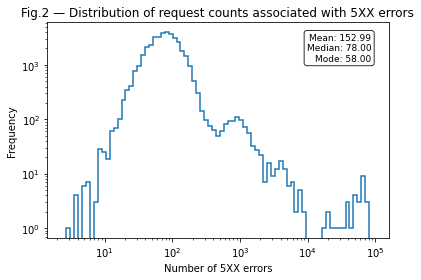

Saved Fig.2 to userData/pivoted_paper_improved/fig2_5xx_distribution.png


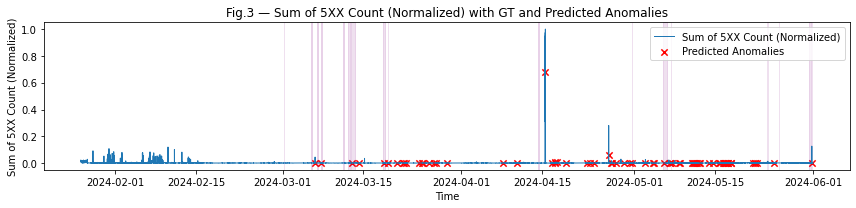

Saved Fig.3 to userData/pivoted_paper_improved/fig3_sum5xx_norm_with_alerts.png


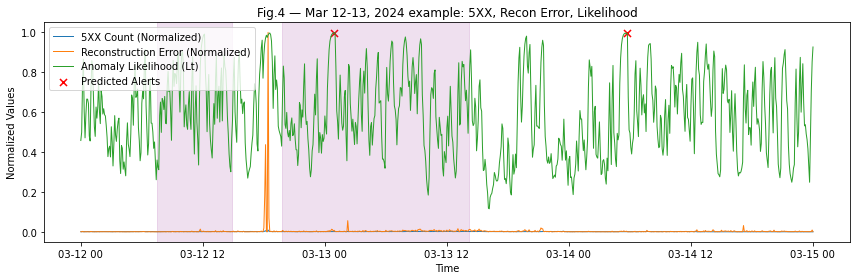

Saved Fig.4 to userData/pivoted_paper_improved/fig4_mar12_13.png


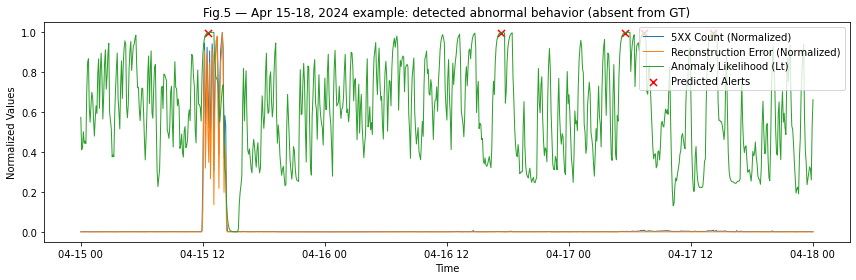

Saved Fig.5 to userData/pivoted_paper_improved/fig5_apr15_18.png

All figures saved to userData/pivoted_paper_improved


In [18]:
def draw_gt_bars(ax, gt_all_df, color='purple', alpha=0.12):
    for _, r in gt_all_df.iterrows():
        ax.axvspan(r['anomaly_start'], r['anomaly_end'], color=color, alpha=alpha)

fig2_path = os.path.join(OUT_DIR, 'fig2_5xx_distribution.png')
counts = df['sum_5xx_count'].fillna(0).values
mean_v = counts.mean() if len(counts)>0 else np.nan
median_v = np.median(counts) if len(counts)>0 else np.nan
try:
    mode_v = stats.mode(counts)[0][0] if len(counts)>0 else np.nan
except Exception:
    mode_v = np.nan

plt.figure(figsize=(6,4))
min_x = max(1, counts.min()+1) if len(counts)>0 else 1
max_x = counts.max()+1 if len(counts)>0 else 1
bins = np.logspace(max(0, np.log10(min_x) - 0.1), np.log10(max_x)+0.1, 80)
plt.hist(counts + 1e-9, bins=bins, density=False, histtype='step', linewidth=1.5)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Number of 5XX errors'); plt.ylabel('Frequency')
plt.title('Fig.2 — Distribution of request counts associated with 5XX errors')
txt = f"Mean: {mean_v:.2f}\nMedian: {median_v:.2f}\nMode: {mode_v:.2f}"
plt.gca().text(0.95, 0.95, txt, transform=plt.gca().transAxes, fontsize=9, va='top', ha='right', bbox=dict(boxstyle='round', fc='white', alpha=0.8))
plt.tight_layout(); plt.savefig(fig2_path, dpi=150); plt.show()
print('Saved Fig.2 to', fig2_path)

sum_5xx = df['sum_5xx_count'].loc[TRAIN_START:TEST_END].fillna(0)
sum_norm = (sum_5xx - sum_5xx.min()) / (sum_5xx.max() - sum_5xx.min() + 1e-12)
events = _mask_to_events_from_mask(pred_full_mask, scores_df.index, event_gap=best["cd"], pct_prob=PCT_PROB)

fig3_path = os.path.join(OUT_DIR, 'fig3_sum5xx_norm_with_alerts.png')
plt.figure(figsize=(12,3))
plt.plot(sum_norm.index, sum_norm.values, label='Sum of 5XX Count (Normalized)', linewidth=1)
ax = plt.gca(); draw_gt_bars(ax, gt_full, color='purple', alpha=0.12)
if len(events):
    ev_idx = pd.to_datetime(events)
    interp_vals = np.interp(pd.to_datetime(ev_idx).astype('int64'), sum_norm.index.astype('int64'), sum_norm.values)
    plt.scatter(ev_idx, interp_vals, marker='x', color='red', s=40, label='Predicted Anomalies')
plt.title('Fig.3 — Sum of 5XX Count (Normalized) with GT and Predicted Anomalies')
plt.xlabel('Time'); plt.ylabel('Sum of 5XX Count (Normalized)'); plt.legend(loc='upper right'); plt.tight_layout()
plt.savefig(fig3_path, dpi=150); plt.show()
print('Saved Fig.3 to', fig3_path)

mse_series = pd.Series(s_t, index=tidx)
lt_series = pd.Series(L_s, index=tidx)

fig4_path = os.path.join(OUT_DIR, 'fig4_mar12_13.png')
start4, end4 = pd.Timestamp("2024-03-12"), pd.Timestamp("2024-03-15")
ix_sum = sum_norm.loc[start4:end4]
ix_mse = mse_series.loc[start4:end4]
ix_lt  = lt_series.loc[start4:end4]
ix_gt  = gt_full[(gt_full['anomaly_start'] >= start4) & (gt_full['anomaly_start'] <= end4)]
plt.figure(figsize=(12,4)); ax = plt.gca()
ax.plot(ix_sum.index, ix_sum.values, label='5XX Count (Normalized)', linewidth=1)
ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Reconstruction Error (Normalized)', linewidth=1)
ax.plot(ix_lt.index, ix_lt.values, label='Anomaly Likelihood (Lt)', linewidth=1)
ev_win = [e for e in events if (e >= start4) and (e <= end4)]
if len(ev_win):
    vals = np.interp(pd.to_datetime(ev_win).astype('int64'), ix_lt.index.astype('int64'), ix_lt.values)
    plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted Alerts')
draw_gt_bars(ax, ix_gt, color='purple', alpha=0.12)
plt.title('Fig.4 — Mar 12-13, 2024 example: 5XX, Recon Error, Likelihood'); plt.xlabel('Time'); plt.ylabel('Normalized Values'); plt.legend(); plt.tight_layout()
plt.savefig(fig4_path, dpi=150); plt.show()
print('Saved Fig.4 to', fig4_path)

fig5_path = os.path.join(OUT_DIR, 'fig5_apr15_18.png')
start5, end5 = pd.Timestamp("2024-04-15"), pd.Timestamp("2024-04-18")
ix_sum = sum_norm.loc[start5:end5]
ix_mse = mse_series.loc[start5:end5]
ix_lt  = lt_series.loc[start5:end5]
ix_gt  = gt_full[(gt_full['anomaly_start'] >= start5) & (gt_full['anomaly_start'] <= end5)]
plt.figure(figsize=(12,4)); ax = plt.gca()
ax.plot(ix_sum.index, ix_sum.values, label='5XX Count (Normalized)', linewidth=1)
ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Reconstruction Error (Normalized)', linewidth=1)
ax.plot(ix_lt.index, ix_lt.values, label='Anomaly Likelihood (Lt)', linewidth=1)
ev_win = [e for e in events if (e >= start5) and (e <= end5)]
if len(ev_win):
    vals = np.interp(pd.to_datetime(ev_win).astype('int64'), ix_lt.index.astype('int64'), ix_lt.values)
    plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted Alerts')
draw_gt_bars(ax, ix_gt, color='purple', alpha=0.12)
plt.title('Fig.5 — Apr 15-18, 2024 example: detected abnormal behavior (absent from GT)'); plt.xlabel('Time'); plt.ylabel('Normalized Values'); plt.legend(); plt.tight_layout()
plt.savefig(fig5_path, dpi=150); plt.show()
print('Saved Fig.5 to', fig5_path)

print("\nAll figures saved to", OUT_DIR)

/home/apps/anaconda3_2018/4.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  


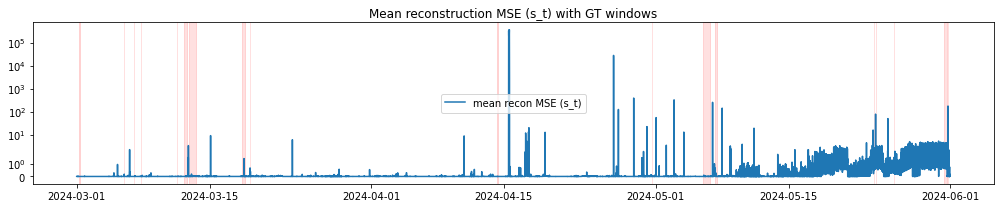

Saved MSE plot to userData/pivoted_paper_improved/improved_diag_mse_with_gt.png


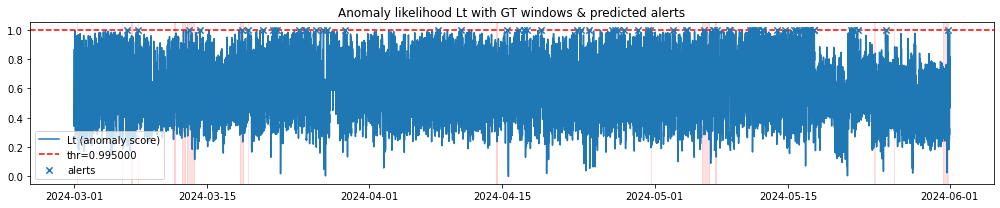

Saved Lt plot to userData/pivoted_paper_improved/improved_diag_lt_with_gt_alerts.png


In [19]:
try:
    plt.figure(figsize=(14,3))
    plt.plot(mse_series, label='mean recon MSE (s_t)')
    for _, r in gt_full.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'], 'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'], 'tz') else pd.to_datetime(r['anomaly_end'])
        plt.axvspan(s, e, color='red', alpha=0.12)
    plt.yscale('symlog', linthresh=1e-6)
    plt.title('Mean reconstruction MSE (s_t) with GT windows'); plt.legend(); plt.tight_layout()
    mse_path = os.path.join(OUT_DIR, "improved_diag_mse_with_gt.png")
    plt.savefig(mse_path, dpi=150); plt.show()
    print("Saved MSE plot to", mse_path)
except Exception as e:
    print('MSE plot error (ignored):', e)

try:
    plt.figure(figsize=(14,3))
    plt.plot(scores_df.index, scores_df['anomaly_score'], label='Lt (anomaly score)')
    plt.axhline(best["thr"], color='red', linestyle='--', label=f'thr={best["thr"]:.6f}')
    for _, r in gt_full.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'], 'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'], 'tz') else pd.to_datetime(r['anomaly_end'])
        plt.axvspan(s, e, color='red', alpha=0.12)
    ev_dt = pd.to_datetime(events)
    if len(ev_dt):
        plt.scatter(ev_dt, [best["thr"]]*len(ev_dt), marker='x', s=40, label='alerts', zorder=5)
    plt.title('Anomaly likelihood Lt with GT windows & predicted alerts')
    plt.legend(); plt.tight_layout()
    lt_path = os.path.join(OUT_DIR, "improved_diag_lt_with_gt_alerts.png")
    plt.savefig(lt_path, dpi=150); plt.show()
    print("Saved Lt plot to", lt_path)
except Exception as e:
    print('Score plot error (ignored):', e)